In [3]:
from constants import EXPRESSION_PATH, CLINICAL_DATA_PATH


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

from sklearn.model_selection import train_test_split
import lightgbm as lgb  

In [4]:
clinical_data = pd.read_csv(CLINICAL_DATA_PATH)
gene_expression = pd.read_csv(EXPRESSION_PATH)

In [5]:
gene_expression.groupby(['Diagnosis'])['Key'].count()

Diagnosis
AD     232
CTL    254
MCI    219
Name: Key, dtype: int64

In [6]:
gene_expression.groupby(['Diagnosis'])['Age'].mean()

Diagnosis
AD     72.697248
CTL    66.327189
MCI    73.736041
Name: Age, dtype: float64

In [7]:
def make_volcano_plot(df, group1_name, group2_name, confidence = 0.95):
    group_column = "Diagnosis"  

    meta_cols = ["Key", "Visit", "Month", "Site", "Diagnosis", "Sex", "Age", "APOE", "MMSE", "Gexp_batch"]
    gene_expression = df.drop(columns=meta_cols)  # оставляем только гены

    group1 = df[df[group_column] == group1_name].index
    group2 = df[df[group_column] == group2_name].index

    dea_results = pd.DataFrame(index=gene_expression.columns)
    p_values = []
    logFC = []

    for gene in gene_expression.columns:
        t_stat, p_val = ttest_ind(gene_expression.loc[group1, gene], gene_expression.loc[group2, gene], equal_var=False)
        p_values.append(p_val)
        
        mean_group1 = gene_expression.loc[group1, gene].mean()
        mean_group2 = gene_expression.loc[group2, gene].mean()
        logFC.append(np.log2(mean_group1 / mean_group2) if mean_group2 != 0 else np.nan)

    dea_results["logFC"] = logFC
    dea_results["p_value"] = p_values

    #dea_results["adj_p_value"] = multipletests(dea_results["p_value"], method="fdr_bh")[1]

    dea_results["Significant"] = "No"
    dea_results.loc[(dea_results["p_value"] < 1 - confidence), "Significant"] = "Yes"

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=dea_results["logFC"], 
        y=-np.log10(dea_results["p_value"]), 
        hue=dea_results["Significant"], 
        palette={"Yes": "red", "No": "gray"}, 
        alpha=0.7
    )
    plt.axhline(-np.log10(1 - confidence), color="black", linestyle="--", linewidth=1)  # Линия порога значимости
    plt.xlabel(f"Log2 Fold Change (left - downregulation, right - upregulation in {group1_name})")
    plt.ylabel("-Log10 P-value")
    plt.title(f"Volcano Plot: {group1_name} vs {group2_name}")
    plt.legend(title="Significance")
    plt.show()

    return dea_results

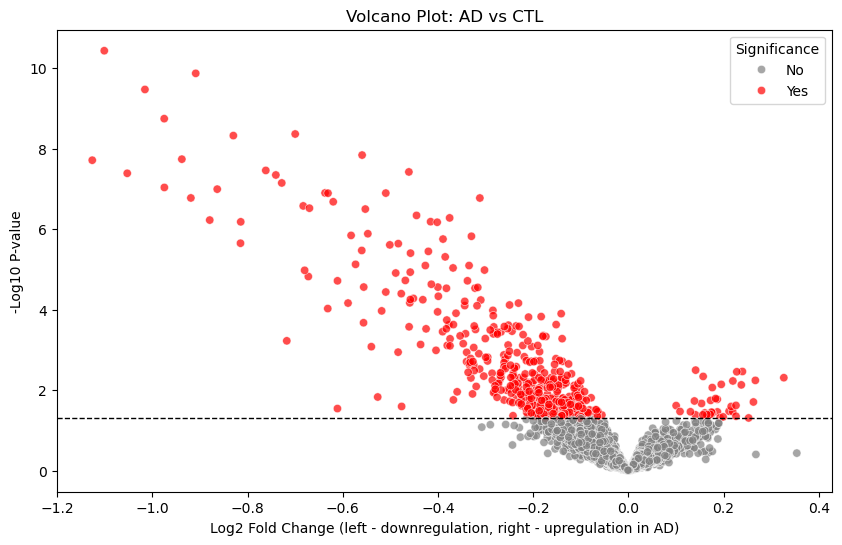

In [8]:
res_1 = make_volcano_plot(gene_expression, "AD", "CTL", confidence=0.95)

In [9]:
res_1.query("Significant == 'Yes'").sort_values("logFC", ascending=False)

,logFC,p_value,Significant
ILMN_1672356,0.326527,4.899945e-03,Yes
ILMN_1711994,0.266724,5.710403e-03,Yes
ILMN_1704870,0.262672,1.963587e-02,Yes
ILMN_1733559,0.252606,4.893513e-02,Yes
ILMN_1660629,0.239526,3.437442e-03,Yes
...,...,...,...
ILMN_1707783,-0.975163,1.813409e-09,Yes
ILMN_1719032,-1.015655,3.416080e-10,Yes
ILMN_1731546,-1.052837,4.117861e-08,Yes
ILMN_1656625,-1.101083,3.728312e-11,Yes


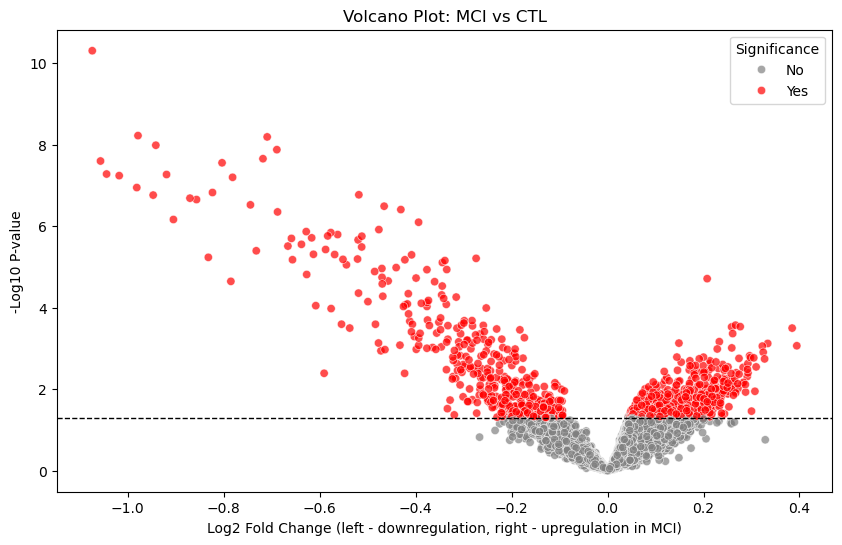

In [10]:
res_2 = make_volcano_plot(gene_expression, "MCI", "CTL", confidence=0.95)

In [11]:
res_2.query('Significant == "Yes"')

,logFC,p_value,Significant
ILMN_1651238,0.062557,0.030880,Yes
ILMN_1651279,0.085007,0.015284,Yes
ILMN_1651328,0.142376,0.008078,Yes
ILMN_1651385,0.172352,0.044714,Yes
ILMN_1651438,0.187417,0.021697,Yes
...,...,...,...
ILMN_1737170,0.207625,0.020304,Yes
ILMN_1737308,-0.440733,0.000010,Yes
ILMN_1737387,0.071223,0.024821,Yes
ILMN_1737396,-0.192750,0.001037,Yes


In [12]:
df = gene_expression[res_1.query('Significant == "Yes"').index.values.tolist() + ['Diagnosis']].query('Diagnosis in ["AD", "CTL"]')

In [13]:
gene_expression

,Key,Visit,Month,Site,Diagnosis,Sex,Age,APOE,MMSE,Gexp_batch,...,ILMN_1737406,ILMN_1737413,ILMN_1737416,ILMN_1737418,ILMN_1737425,ILMN_1737426,ILMN_1737430,ILMN_1737433,ILMN_1737434,ILMN_1737435
0,DCR00001_1,1,0,DCR,AD,Female,80.0,E3E4,21.0,2.0,...,780.100000,82.1000,76.8000,86.6000,74.40000,107.2000,76.8000,76.7000,73.0000,74.00000
1,DCR00004_1,1,0,DCR,MCI,Male,78.0,E4E4,27.0,2.0,...,1812.900000,118.7000,109.6000,116.7000,95.10000,568.2000,91.7000,93.9000,94.8000,87.30000
2,DCR00009_1,1,0,DCR,CTL,Female,69.0,E3E3,30.0,2.0,...,1235.800000,87.7000,94.8000,106.4000,83.20000,132.8000,81.7000,85.5000,81.6000,79.90000
3,DCR00013_1,1,0,DCR,CTL,Male,82.0,E3E3,30.0,2.0,...,1020.000000,89.6000,84.3000,95.0000,82.90000,214.1000,76.8000,81.1000,78.2000,76.60000
4,DCR00014_1,1,0,DCR,CTL,Female,75.0,E2E3,30.0,2.0,...,438.700000,83.6000,80.9000,92.5000,75.70000,137.1000,78.0000,78.1000,78.3000,78.70000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,TLSMCI608_1,1,0,Toulouse,MCI,Male,73.0,E3E3,28.0,1.0,...,2692.393008,117.8118,121.2486,136.1811,111.12510,177.3843,126.5258,123.6391,116.5386,125.65210
701,TLSMCI609_1,1,0,Toulouse,MCI,Female,63.0,E3E3,28.0,2.0,...,618.800000,91.0000,85.3000,92.3000,85.60000,165.8000,83.6000,78.4000,80.0000,79.40000
702,TLSMCI610_1,1,0,Toulouse,MCI,Male,73.0,E3E3,29.0,NaN,...,123.500000,76.4000,73.1000,87.4000,74.70000,73.2000,74.3000,79.7000,75.9000,75.60000
703,TLSMCI611_1,1,0,Toulouse,MCI,Female,78.0,E3E3,30.0,2.0,...,881.200000,95.4000,98.4000,103.5000,91.30000,177.5000,95.8000,87.8000,90.7000,83.50000


/Users/albertbay/opt/anaconda3/envs/Alzheimer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'num_leaves': 15}
Accuracy: 0.6837


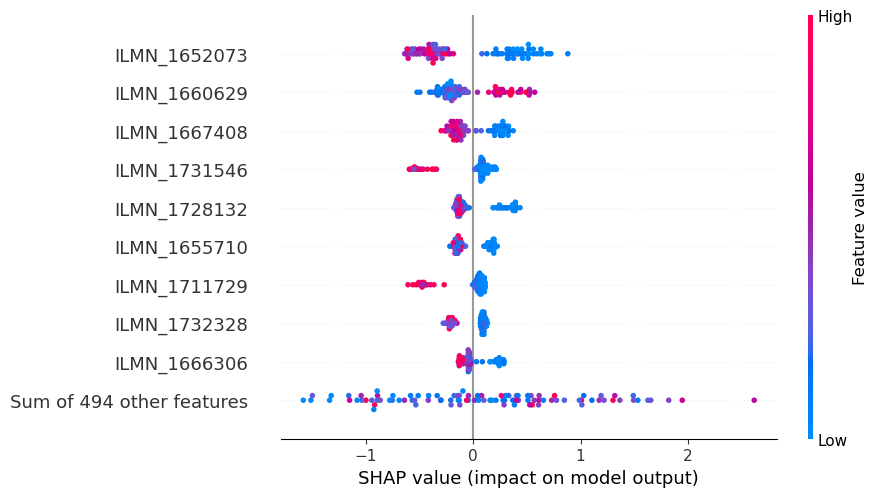

In [14]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score

# Пример данных (предположительно df уже загружен)
diagnosis = {'CTL': 0, 'AD': 1}
df['Diagnosis'] = df['Diagnosis'].map(diagnosis)  # Преобразуем целевые переменные в числовой формат

# Разделение данных
X = df.drop(columns=['Diagnosis'])  # Фичи
y = df['Diagnosis']  # Целевая переменная

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение сетки гиперпараметров
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 63],
    'max_depth': [-1, 5, 10],
    'n_estimators': [100, 200, 500]
}

# Инициализация модели LightGBM
lgbm = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', metric='logloss', verbose=-1)

# Подбор гиперпараметров с кросс-валидацией
grid_search = GridSearchCV(lgbm, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print("Лучшие параметры:", grid_search.best_params_)

# Обучение модели с лучшими параметрами
best_lgbm = grid_search.best_estimator_
best_lgbm.fit(X_train, y_train)

# Оценка точности
y_pred = best_lgbm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Вычисление SHAP значений
explainer = shap.Explainer(best_lgbm, X_train)
shap_values = explainer(X_test)

# Визуализация SHAP значений
shap.plots.beeswarm(shap_values)
plt.show()
